<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


# 1. Initialize

In [ ]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'trained_models',
 'DataPreprocessing.ipynb',
 'checkpoints',
 'Heatmap_each.ipynb',
 'Update_leaf.ipynb']

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from utils.hourglass import *
from utils.dataloader import *
from utils.heatmap_utils import *

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim_tree = 5 # how deep the regression tree is 
num_tree = 3 # number of regression trees
variance_gaussian = 3

num_fc = int(num_tree*(2**(dim_tree-1)-1))
num_leaf_nodes = int(num_tree*2**(dim_tree-1))

# 2. Data Loader

In [ ]:
helen_trainset = Helen_set(dataset_type="train",var=variance_gaussian)

Loading [1/2000] pictures......


In [ ]:
helen_testset = Helen_set(dataset_type="test",var=variance_gaussian)

In [ ]:
train_dataloder = DataLoader(helen_trainset, batch_size=30)
test_dataloder = DataLoader(helen_testset, batch_size=30)

# 3. Pre Train

In [ ]:
helen_sampleset = Helen_set(dataset_type="sample")
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

In [ ]:
critical = torch.nn.MSELoss()

nIters = 200
HGNet = HGNet().to(device)
optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
loss_hist = torch.zeros(nIters)
loss_epoch = torch.zeros(10)

for iter in range(nIters):
  for i, (x,_,y) in enumerate(sample_dataloder):
    x = Variable(x,requires_grad=True).float().to(device)
    y = Variable(y).float().to(device)
    y_pred = HGNet.forward(x)
    loss = critical(y_pred, y)
    loss_epoch[i] = loss.item()

    if i == 9:
      loss_avg = torch.sum(loss_epoch)/10
      loss_hist[iter] = loss_avg
      if (iter+1)%10 == 0 or iter == 0:
        print('Iter [%d/%d] loss %.4f' %(iter+1, nIters, loss_avg))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
plt.title("Training Loss")

In [ ]:
# torch.save(HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt")

# 4. Tune Training

## 4.1 Sample Set

In [ ]:
helen_sampleset = Helen_set(dataset_type="sample",var=variance_gaussian)
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)
helen_sampletest = Helen_set(dataset_type="sample_test",var=variance_gaussian)
sample_test_dataloder = DataLoader(helen_sampletest, batch_size=10)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......
Loading [1/30] pictures......


## 4.2 Network

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

<All keys matched successfully>

In [ ]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

## 4.3 Training

In [ ]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 1000

criterion_MSE = torch.nn.MSELoss()
criterion_KL = torch.nn.KLDivLoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 60

### Training using L2 Loss

In [ ]:
# Using L2 Loss

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))
  
  #####################################
  ### Train Hourglass
  ### eyes: [36:48]
  #####################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12,256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)
      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,256,256)

      # get mask for computing cnn loss
      cnn_mask = get_mask(cnn_heatmaps,threshold=0.5)
      loss = criterion_MSE(cnn_heatmaps*cnn_mask, y[:,36:48,:,:]*cnn_mask)
      loss_epoch += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  
    if (iter+1)%20 == 0 or iter == 0:
      print('     CNN training, Iter [%d/%d], loss_L2: %.8f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))

  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))


  #####################################
  ### Train Regression Trees using pinv
  #####################################
  with torch.no_grad():
    leaf_q_new = torch.zeros(num_leaf_nodes,12,256*256).to(device)
    loss0 = 0

    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

      leaf_q_this = torch.matmul(torch.linalg.pinv(cnn_prob), y_expand) #(8,12*256*256)
      leaf_q_new += leaf_q_this.reshape(num_leaf_nodes,12,-1)

      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q_this.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

      
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    
    # Sharpen Leaf_q
    # for nleaf in range(num_leaf_nodes):
    #   for npoints in range(12):
    #     leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    # leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    # leaf_q = leaf_q.reshape(num_leaf_nodes,-1)

    print("     RF training, coordinate loss: %.4f" %(loss0/10))

  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_L2_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round)+'.pt'))
  torch.save(leaf_q, os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_L2_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round)+'.pt'))

  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_L2_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_L2_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))



### Training using Log likelihood

############################################################################
Round [1/10], Using GPU
     CNN training, Iter [1/30], loss_KL: 3.8547692
     -----> CNN training time: ## 2.69 mins ## 


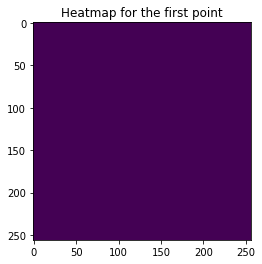

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8559
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8560
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8560
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8560
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8558
     RF training, coordinate loss: 5655.2954


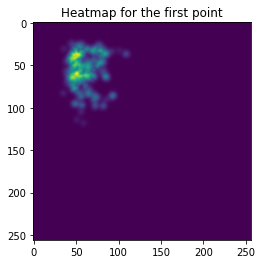

     -----> RF training time: ## 9.97 mins ## 
     -----> Training time for this round: ## 12.67 mins ## 
############################################################################
Round [2/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8550767
     CNN training, Iter [50/1000], loss_KL: 3.8550762
     CNN training, Iter [100/1000], loss_KL: 3.8550759
     CNN training, Iter [150/1000], loss_KL: 3.8550754
     CNN training, Iter [200/1000], loss_KL: 3.8550751
     CNN training, Iter [250/1000], loss_KL: 3.8550748
     CNN training, Iter [300/1000], loss_KL: 3.8550744
     CNN training, Iter [350/1000], loss_KL: 3.8550742
     CNN training, Iter [400/1000], loss_KL: 3.8550738
     CNN training, Iter [450/1000], loss_KL: 3.8550734
     CNN training, Iter [500/1000], loss_KL: 3.8550732
     CNN training, Iter [550/1000], loss_KL: 3.8550728
     CNN training, Iter [600/1000], loss_KL: 3.8550725
     CNN training, Iter [650/1000], loss_KL: 3.8550721
     CNN training, Iter [

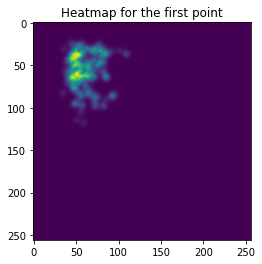

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8559
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8559
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8559
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8559
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8558
     RF training, coordinate loss: 6096.8496


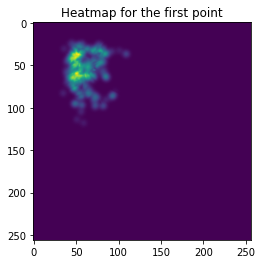

     -----> RF training time: ## 9.86 mins ## 
     -----> Training time for this round: ## 99.12 mins ## 
############################################################################
Round [3/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8550719
     CNN training, Iter [50/1000], loss_KL: 3.8550716
     CNN training, Iter [100/1000], loss_KL: 3.8550712
     CNN training, Iter [150/1000], loss_KL: 3.8550710
     CNN training, Iter [200/1000], loss_KL: 3.8550706
     CNN training, Iter [250/1000], loss_KL: 3.8550702
     CNN training, Iter [300/1000], loss_KL: 3.8550701
     CNN training, Iter [350/1000], loss_KL: 3.8550697
     CNN training, Iter [400/1000], loss_KL: 3.8550695
     CNN training, Iter [450/1000], loss_KL: 3.8550692
     CNN training, Iter [500/1000], loss_KL: 3.8550688
     CNN training, Iter [550/1000], loss_KL: 3.8550688
     CNN training, Iter [600/1000], loss_KL: 3.8550685
     CNN training, Iter [650/1000], loss_KL: 3.8550680
     CNN training, Iter [

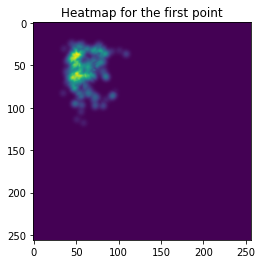

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8559
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8559
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8559
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8558
     RF training, coordinate loss: 6372.0669


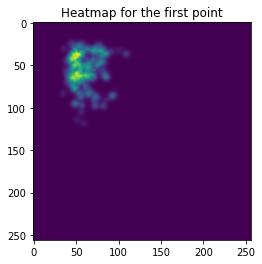

     -----> RF training time: ## 9.99 mins ## 
     -----> Training time for this round: ## 99.07 mins ## 
############################################################################
Round [4/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8550671
     CNN training, Iter [50/1000], loss_KL: 3.8550668
     CNN training, Iter [100/1000], loss_KL: 3.8550665
     CNN training, Iter [150/1000], loss_KL: 3.8550662
     CNN training, Iter [200/1000], loss_KL: 3.8550660
     CNN training, Iter [250/1000], loss_KL: 3.8550658
     CNN training, Iter [300/1000], loss_KL: 3.8550655
     CNN training, Iter [350/1000], loss_KL: 3.8550653
     CNN training, Iter [400/1000], loss_KL: 3.8550651
     CNN training, Iter [450/1000], loss_KL: 3.8550649
     CNN training, Iter [500/1000], loss_KL: 3.8550645
     CNN training, Iter [550/1000], loss_KL: 3.8550643
     CNN training, Iter [600/1000], loss_KL: 3.8550641
     CNN training, Iter [650/1000], loss_KL: 3.8550640
     CNN training, Iter [

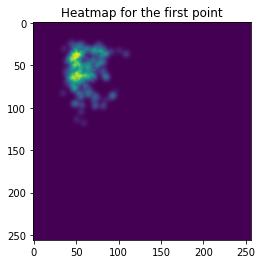

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8557
     RF training, coordinate loss: 6586.7104


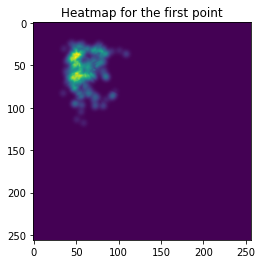

     -----> RF training time: ## 9.92 mins ## 
     -----> Training time for this round: ## 98.66 mins ## 
############################################################################
Round [5/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8550630
     CNN training, Iter [50/1000], loss_KL: 3.8550626
     CNN training, Iter [100/1000], loss_KL: 3.8550625
     CNN training, Iter [150/1000], loss_KL: 3.8550622
     CNN training, Iter [200/1000], loss_KL: 3.8550620
     CNN training, Iter [250/1000], loss_KL: 3.8550618
     CNN training, Iter [300/1000], loss_KL: 3.8550617
     CNN training, Iter [350/1000], loss_KL: 3.8550614
     CNN training, Iter [400/1000], loss_KL: 3.8550613
     CNN training, Iter [450/1000], loss_KL: 3.8550611
     CNN training, Iter [500/1000], loss_KL: 3.8550609
     CNN training, Iter [550/1000], loss_KL: 3.8550607
     CNN training, Iter [600/1000], loss_KL: 3.8550605
     CNN training, Iter [650/1000], loss_KL: 3.8550604
     CNN training, Iter [

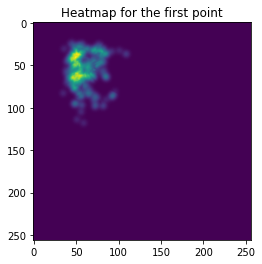

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8557
     RF training, coordinate loss: 6771.1274


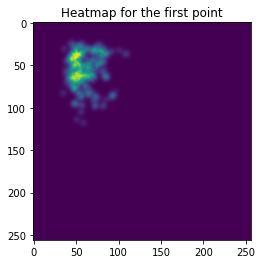

     -----> RF training time: ## 9.83 mins ## 
     -----> Training time for this round: ## 98.91 mins ## 
############################################################################
Round [6/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8550595
     CNN training, Iter [50/1000], loss_KL: 3.8550593
     CNN training, Iter [100/1000], loss_KL: 3.8550591
     CNN training, Iter [150/1000], loss_KL: 3.8550590
     CNN training, Iter [200/1000], loss_KL: 3.8550589
     CNN training, Iter [250/1000], loss_KL: 3.8550587
     CNN training, Iter [300/1000], loss_KL: 3.8550584
     CNN training, Iter [350/1000], loss_KL: 3.8550583
     CNN training, Iter [400/1000], loss_KL: 3.8550583
     CNN training, Iter [450/1000], loss_KL: 3.8550580
     CNN training, Iter [500/1000], loss_KL: 3.8550579
     CNN training, Iter [550/1000], loss_KL: 3.8550577
     CNN training, Iter [600/1000], loss_KL: 3.8550576
     CNN training, Iter [650/1000], loss_KL: 3.8550575
     CNN training, Iter [

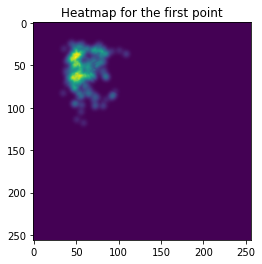

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8558
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8558
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8557
     RF training, coordinate loss: 6871.8291


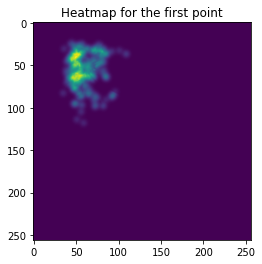

     -----> RF training time: ## 9.83 mins ## 
     -----> Training time for this round: ## 98.60 mins ## 
############################################################################
Round [7/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8550567
     CNN training, Iter [50/1000], loss_KL: 3.8550567
     CNN training, Iter [100/1000], loss_KL: 3.8550564
     CNN training, Iter [150/1000], loss_KL: 3.8550564
     CNN training, Iter [200/1000], loss_KL: 3.8550562
     CNN training, Iter [250/1000], loss_KL: 3.8550561
     CNN training, Iter [300/1000], loss_KL: 3.8550559
     CNN training, Iter [350/1000], loss_KL: 3.8550557
     CNN training, Iter [400/1000], loss_KL: 3.8550557
     CNN training, Iter [450/1000], loss_KL: 3.8550556
     CNN training, Iter [500/1000], loss_KL: 3.8550553
     CNN training, Iter [550/1000], loss_KL: 3.8550553
     CNN training, Iter [600/1000], loss_KL: 3.8550550
     CNN training, Iter [650/1000], loss_KL: 3.8550549
     CNN training, Iter [

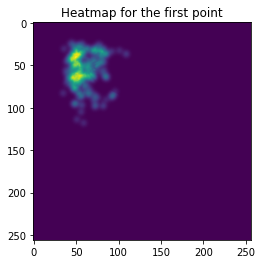

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8556
     RF training, coordinate loss: 6918.7627


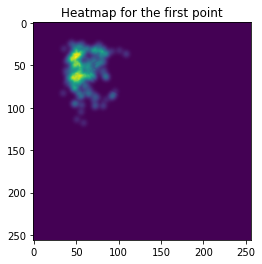

     -----> RF training time: ## 9.77 mins ## 
     -----> Training time for this round: ## 98.46 mins ## 
############################################################################
Round [8/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8550543
     CNN training, Iter [50/1000], loss_KL: 3.8550542
     CNN training, Iter [100/1000], loss_KL: 3.8550542
     CNN training, Iter [150/1000], loss_KL: 3.8550541
     CNN training, Iter [200/1000], loss_KL: 3.8550540
     CNN training, Iter [250/1000], loss_KL: 3.8550539
     CNN training, Iter [300/1000], loss_KL: 3.8550538
     CNN training, Iter [350/1000], loss_KL: 3.8550537
     CNN training, Iter [400/1000], loss_KL: 3.8550536
     CNN training, Iter [450/1000], loss_KL: 3.8550535
     CNN training, Iter [500/1000], loss_KL: 3.8550534
     CNN training, Iter [550/1000], loss_KL: 3.8550533
     CNN training, Iter [600/1000], loss_KL: 3.8550530
     CNN training, Iter [650/1000], loss_KL: 3.8550529
     CNN training, Iter [

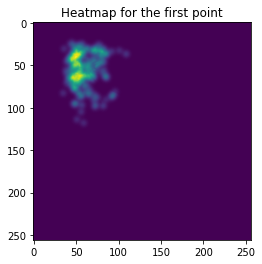

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8556
     RF training, coordinate loss: 7001.3008


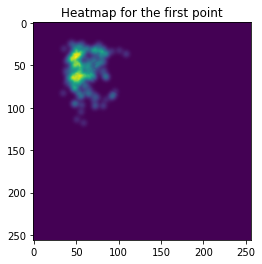

     -----> RF training time: ## 9.79 mins ## 
     -----> Training time for this round: ## 98.42 mins ## 
############################################################################
Round [9/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8550525
     CNN training, Iter [50/1000], loss_KL: 3.8550525
     CNN training, Iter [100/1000], loss_KL: 3.8550523
     CNN training, Iter [150/1000], loss_KL: 3.8550522
     CNN training, Iter [200/1000], loss_KL: 3.8550521
     CNN training, Iter [250/1000], loss_KL: 3.8550521
     CNN training, Iter [300/1000], loss_KL: 3.8550520
     CNN training, Iter [350/1000], loss_KL: 3.8550520
     CNN training, Iter [400/1000], loss_KL: 3.8550519
     CNN training, Iter [450/1000], loss_KL: 3.8550518
     CNN training, Iter [500/1000], loss_KL: 3.8550517
     CNN training, Iter [550/1000], loss_KL: 3.8550515
     CNN training, Iter [600/1000], loss_KL: 3.8550514
     CNN training, Iter [650/1000], loss_KL: 3.8550514
     CNN training, Iter [

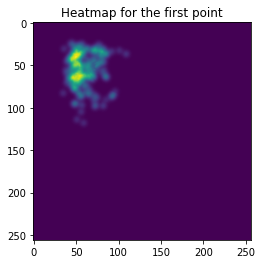

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8556
     RF training, coordinate loss: 7058.1714


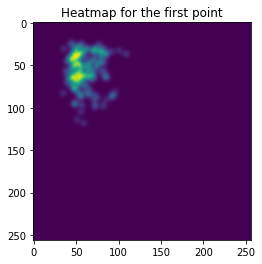

     -----> RF training time: ## 9.78 mins ## 
     -----> Training time for this round: ## 98.46 mins ## 
############################################################################
Round [10/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8550511
     CNN training, Iter [50/1000], loss_KL: 3.8550509
     CNN training, Iter [100/1000], loss_KL: 3.8550508
     CNN training, Iter [150/1000], loss_KL: 3.8550508
     CNN training, Iter [200/1000], loss_KL: 3.8550508
     CNN training, Iter [250/1000], loss_KL: 3.8550506
     CNN training, Iter [300/1000], loss_KL: 3.8550506
     CNN training, Iter [350/1000], loss_KL: 3.8550506
     CNN training, Iter [400/1000], loss_KL: 3.8550505
     CNN training, Iter [450/1000], loss_KL: 3.8550504
     CNN training, Iter [500/1000], loss_KL: 3.8550503
     CNN training, Iter [550/1000], loss_KL: 3.8550503
     CNN training, Iter [600/1000], loss_KL: 3.8550503
     CNN training, Iter [650/1000], loss_KL: 3.8550502
     CNN training, Iter 

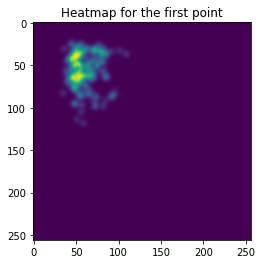

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8557
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8557
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8555
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8556
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8556
     RF training, coordinate loss: 7103.5181


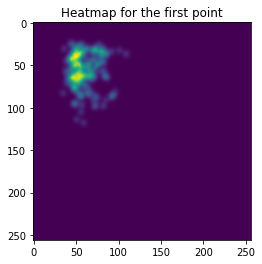

     -----> RF training time: ## 9.77 mins ## 
     -----> Training time for this round: ## 98.49 mins ## 
-----> Total training time: ## 15.01 hrs ## 


In [ ]:
# update using log likelihood

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))

  
  ######################################################
  ### Train Hourglass
  ### eyes: [36:48]
  ######################################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12,256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs, num_leaf_nodes, dim_tree, num_tree)

      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
      cnn_heatmaps = cnn_heatmaps/torch.sum(cnn_heatmaps,axis=1,keepdims=True)
      label_heatmaps = y[:,36:48,:,:].reshape(B*12,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)

      loss = -criterion_KL(cnn_heatmaps,label_heatmaps)
      loss_epoch += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if (iter+1)%50 == 0 or iter == 0:
      print('     CNN training, Iter [%d/%d], loss_KL: %.7f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))


  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))

  plt.imshow(cnn_heatmaps[0,:].reshape(256,256).detach().cpu())
  plt.title("Round"+str(round+1)+"_CNN")
  plt.savefig(os.path.join("checkpoints/var_"+str(variance_gaussian),"Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN.png"))
  plt.show()


  ######################################################
  ### Train Regression Trees using variational bounding
  ######################################################
  with torch.no_grad():
    loss0 = 0

    leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    next_leaf_q = torch.zeros(leaf_q.shape).to(device)

    for i, (x,coord,y) in enumerate(sample_dataloder):
      new_leaf_q = leaf_q.clone()
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,12,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs, num_leaf_nodes, dim_tree, num_tree)

  
      for rf_iter in range(rf_Iters):
        for points_id in range(12):
          new_leaf_q[:,points_id,:] = update_iter(new_leaf_q[:,points_id,:], cnn_prob, y_expand[:,points_id,:])
        if ((i+1)%4 == 0 or i == 0) and ((rf_iter+1)%15 == 0 or rf_iter == 0):
          rf_loss_CE = loss_ce(B, new_leaf_q, cnn_prob, y_expand, num_leaf_nodes)
          print("     RF training, Batch %d, rf_iter [%d/%d], loss_KL: %.4f" %(i+1, rf_iter+1, rf_Iters, rf_loss_CE*224*224))
      next_leaf_q += new_leaf_q

      pred_coord0 = find_coord(torch.matmul(cnn_prob,new_leaf_q.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

    # normalize
    leaf_q = next_leaf_q/torch.sum(next_leaf_q,axis=2,keepdims=True)

    # Sharpen Leaf_q
    # leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    # for nleaf in range(num_leaf_nodes):
    #   for npoints in range(12):
    #     leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    # leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    # leaf_q = leaf_q.reshape(num_leaf_nodes,-1)


    print("     RF training, coordinate loss: %.4f" %(loss0/10))

  rf_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  plt.imshow(rf_heatmaps[0,:].reshape(256,256).detach().cpu())
  plt.title("Round"+str(round+1)+"_RF")
  plt.savefig(os.path.join("checkpoints/var_"+str(variance_gaussian),"Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF.png"))
  plt.show()

  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))
  torch.save(leaf_q, os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))

  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

## 4.4 Test

### Restore from saved weights

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round1.pt")))
leaf_q = torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round1.pt"))

In [ ]:
import torchsummary
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
torchsummary.summary(Tune_HGNet, (3,256,256))
print('parameters_count:',count_parameters(Tune_HGNet))

### Test

In [ ]:
heatmap_loss, coord_loss = 0, 0
Tune_HGNet.eval()
criterion = torch.nn.MSELoss()

for i, (img,coord,hm) in enumerate(sample_test_dataloder):
  img = img.float().to(device)
  img.requires_grad = True
  coord = coord.float().to(device)
  hm = hm.float().to(device)
  B = img.shape[0]
  
  outputs = Tune_HGNet.forward(img)
  cnn_prob = phi(outputs, num_leaf_nodes, dim_tree, num_tree)
  pred_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)) #(15,12*256*256)
  pred_coords = find_coord(pred_heatmaps) #(15,12*2)

  heatmap_loss += criterion(pred_heatmaps, hm[:,36:48,:,:].reshape(B,-1))
  coord_loss += torch.sum(torch.abs(pred_coords-coord[:,36:48,:].reshape(B,-1)))

print("Heatmap loss %.8f, Coord loss %.4f" %(heatmap_loss/10, coord_loss/10))

Heatmap loss 0.00000005, Coord loss 977.7588
Heatmap loss 0.00000005, Coord loss 977.7588


In [ ]:
phi(outputs, num_leaf_nodes, dim_tree, num_tree)[0:5,:]

tensor([[0.0649, 0.0600, 0.0668, 0.0654, 0.0588, 0.0566, 0.0579, 0.0536, 0.0640,
         0.0643, 0.0642, 0.0661, 0.0733, 0.0656, 0.0588, 0.0596, 0.0578, 0.0639,
         0.0569, 0.0581, 0.0610, 0.0703, 0.0627, 0.0651, 0.0598, 0.0545, 0.0655,
         0.0715, 0.0653, 0.0587, 0.0654, 0.0636, 0.0598, 0.0712, 0.0581, 0.0613,
         0.0566, 0.0592, 0.0557, 0.0573, 0.0623, 0.0699, 0.0735, 0.0713, 0.0595,
         0.0572, 0.0634, 0.0638],
        [0.0604, 0.0590, 0.0649, 0.0630, 0.0665, 0.0700, 0.0566, 0.0600, 0.0601,
         0.0662, 0.0647, 0.0630, 0.0646, 0.0588, 0.0608, 0.0614, 0.0630, 0.0605,
         0.0615, 0.0625, 0.0599, 0.0670, 0.0606, 0.0626, 0.0597, 0.0576, 0.0647,
         0.0606, 0.0697, 0.0614, 0.0633, 0.0654, 0.0617, 0.0727, 0.0569, 0.0618,
         0.0598, 0.0557, 0.0569, 0.0599, 0.0650, 0.0638, 0.0671, 0.0676, 0.0592,
         0.0598, 0.0671, 0.0652],
        [0.0606, 0.0566, 0.0661, 0.0612, 0.0557, 0.0541, 0.0606, 0.0577, 0.0667,
         0.0669, 0.0710, 0.0715, 0.0649, 

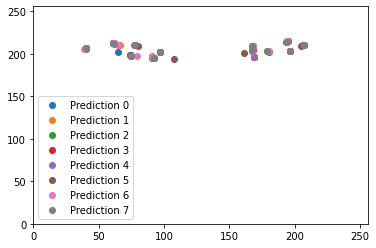

In [ ]:
for ith in range(8):
  x = pred_coords[ith,::2].detach().cpu()
  y = pred_coords[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction %d" %ith)

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)

(0.0, 256.0)

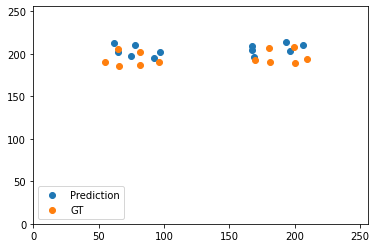

In [ ]:
ith = 0

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

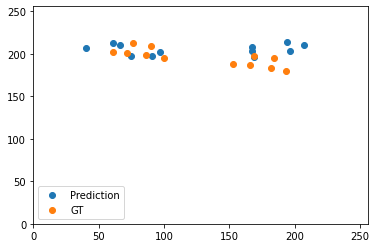

In [ ]:
ith = 1

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

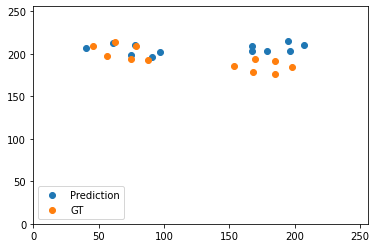

In [ ]:
ith = 2

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

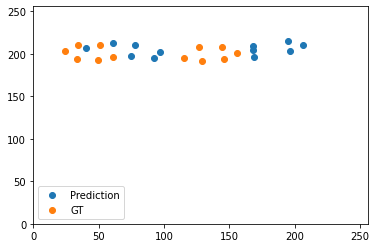

In [ ]:
ith = 3

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

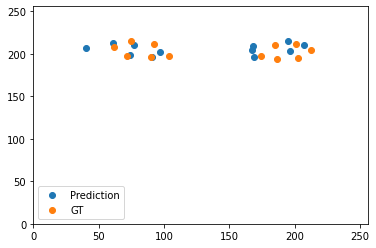

In [ ]:
ith = 4

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

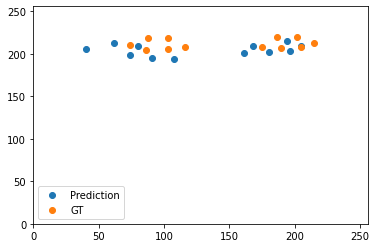

In [ ]:
ith = 5

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

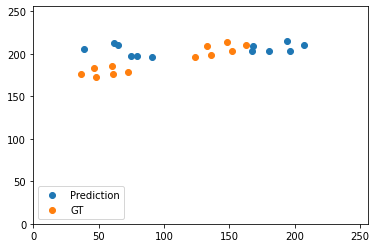

In [ ]:
ith = 6

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

(0.0, 256.0)

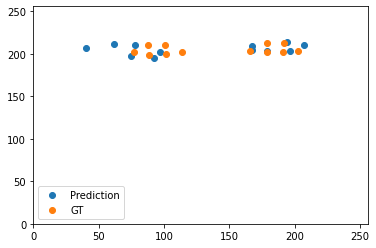

In [ ]:
ith = 7

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

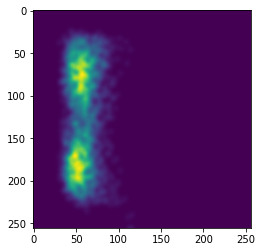

In [ ]:
plot_heatmaps = pred_heatmaps.reshape(B,12,256,256).detach().cpu()
plot_heatmaps_all = torch.sum(plot_heatmaps,axis=1)
plt.imshow(plot_heatmaps_all[ith,:,:])

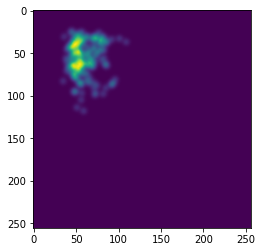

In [ ]:
# one point
plt.imshow(plot_heatmaps[ith,0,:,:])

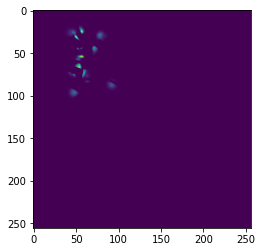

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[0,0,:,:].detach().cpu())

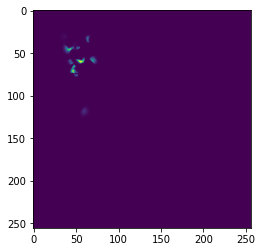

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[1,0,:,:].detach().cpu())

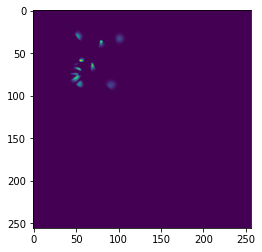

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[2,0,:,:].detach().cpu())

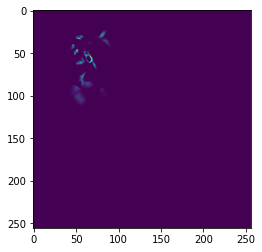

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[3,0,:,:].detach().cpu())

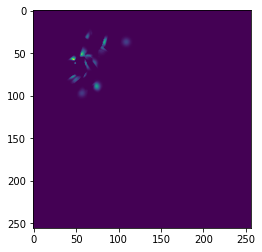

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[4,0,:,:].detach().cpu())

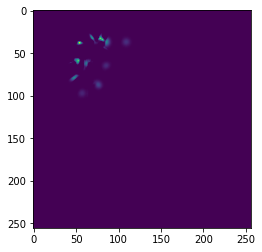

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[5,0,:,:].detach().cpu())

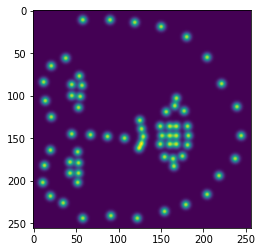

In [ ]:
image = torch.sum(hm, axis=1).detach().cpu()
plt.imshow(image[ith,:,:])

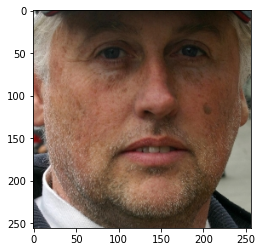

In [ ]:
plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())